# Árvores II - Tarefa 2

### 1. Carregar as bases

Vamos carregar as bases lidas na tarefa passada. Se você salvou essas bases em arquivo texto, basta fazer a leitura com o comando ```pd.read_csv``` das seguintes bases:

- X_train
- Y_train
- X_test
- Y_test

Não se esqueça de considerar a leitura dos índices dos arquivos no ```read_csv()```!

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay

In [7]:
import pandas as pd

# Ler as bases de entrada (features)
X_train = pd.read_csv("x_train_preparado.csv", index_col=[0, 1])
X_test = pd.read_csv("x_test_preparado.csv", index_col=[0, 1])

# Ler as bases de saída (rótulos)
y_train = pd.read_csv("y_train.csv", index_col=0)
y_test = pd.read_csv("y_test.csv", index_col=0)

# Renomear a coluna se necessário
if y_train.shape[1] == 0:
    y_train = y_train.rename_axis("atividade").reset_index()
if y_test.shape[1] == 0:
    y_test = y_test.rename_axis("atividade").reset_index()

print("✅ Bases carregadas com sucesso!\n")
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

print("\nPré-visualização de y_train:")
print(y_train.head())

✅ Bases carregadas com sucesso!

X_train: (7352, 562)
X_test: (2947, 562)
y_train: (7352, 1)
y_test: (2947, 1)

Pré-visualização de y_train:
  atividade
0  STANDING
1  STANDING
2  STANDING
3  STANDING
4  STANDING


### 2. Divisão da base em Treino, Validação e Teste

A base já se encontra dividida em Treino e Validação. O que vamos fazer então é extrair uma base de Validação da base de Treino.

Extraia 25% da base de treino como base de validação.

In [8]:
from sklearn.model_selection import train_test_split

# Separar 25% da base de treino para validação
X_treino, X_val, y_treino, y_val = train_test_split(
    X_train,
    y_train,
    test_size=0.25,
    random_state=42,
    stratify=y_train  # garante proporções equilibradas entre as classes
)

print("✅ Divisão concluída com sucesso!\n")
print("X_treino:", X_treino.shape)
print("X_val:", X_val.shape)
print("y_treino:", y_treino.shape)
print("y_val:", y_val.shape)

✅ Divisão concluída com sucesso!

X_treino: (5514, 562)
X_val: (1838, 562)
y_treino: (5514, 1)
y_val: (1838, 1)


### 3. Melhores 3 variáveis

Rode uma árvore com profundidade máxima igual a 4 para prever a atividade humana com todas as variáveis.
Observe a importância das variáveis e considere as 3 variáveis com maior importância para os próximos passos.
Dica: utilize o atributo ```clf.feature_importances_``` da árvore treinada.

Árvore treinada com profundidade máxima = 4

Três variáveis mais importantes:
tGravityAcc-min()-X     0.282271
fBodyAcc-mad()-X        0.253685
angle(Y,gravityMean)    0.170814
dtype: float64


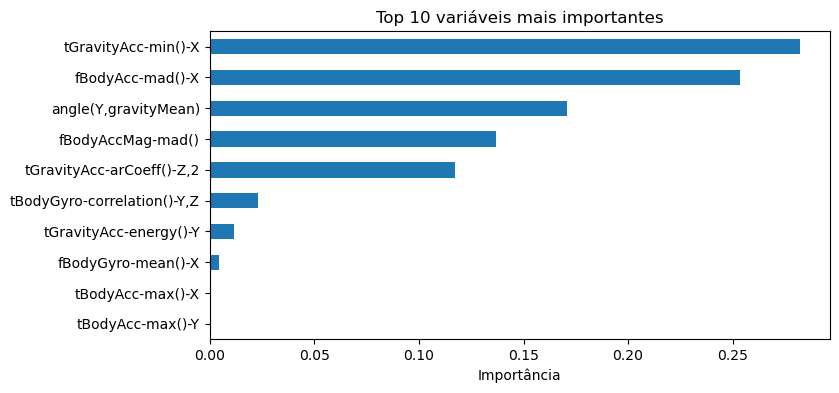

In [10]:
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
import numpy as np

# Treinar uma árvore de decisão com profundidade máxima = 4
arvore = DecisionTreeClassifier(max_depth=4, random_state=42)
arvore.fit(X_treino, y_treino)

# Obter importâncias das variáveis
importancias = pd.Series(arvore.feature_importances_, index=X_treino.columns)
importancias_ordenadas = importancias.sort_values(ascending=False)

# Mostrar as 3 variáveis mais importantes
top3 = importancias_ordenadas.head(3)
print("Árvore treinada com profundidade máxima = 4")
print("\nTrês variáveis mais importantes:")
print(top3)

# Gráfico para visualizar a importância das 10 mais relevantes
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
top10 = importancias_ordenadas.head(10)
top10.plot(kind='barh')
plt.gca().invert_yaxis()
plt.title("Top 10 variáveis mais importantes")
plt.xlabel("Importância")
plt.show()

A árvore de decisão identificou que as variáveis tGravityAcc-min()-X, fBodyAcc-mad()-X e angle(Y,gravityMean) são as mais relevantes para distinguir as atividades humanas.
Essas variáveis representam medidas relacionadas à aceleração da gravidade e à variabilidade do movimento, o que faz sentido, pois elas capturam diferenças importantes entre atividades estáticas (como sentar e deitar) e dinâmicas (como andar ou subir escadas).

### 4. Construa uma árvore com as 3 melhores variáveis

Utilizando as três variáveis encontradas acima, construa uma árvore de decisão. Encontre o melhor ```ccp_alpha``` utilizando a base de validação, conforme a estrutura que vimos em aula.

In [11]:
%%time
from sklearn.tree import DecisionTreeClassifier

# Selecionar as 3 variáveis mais importantes identificadas anteriormente
melhores_variaveis = ['tGravityAcc-min()-X', 'fBodyAcc-mad()-X', 'angle(Y,gravityMean)']

# Filtrar apenas essas variáveis nas bases
X_treino_reduzido = X_treino[melhores_variaveis]
X_val_reduzido = X_val[melhores_variaveis]
X_test_reduzido = X_test[melhores_variaveis]

# Treinar árvore base
arvore_base = DecisionTreeClassifier(random_state=42)
path = arvore_base.cost_complexity_pruning_path(X_treino_reduzido, y_treino)
ccp_alphas = np.unique(path.ccp_alphas[path.ccp_alphas > 0])  # apenas positivos e únicos

# Treinar uma árvore para cada alpha
arvores = []
for alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=42, ccp_alpha=alpha)
    clf.fit(X_treino_reduzido, y_treino)
    arvores.append(clf)

print(f"Total de árvores treinadas com diferentes valores de alpha: {len(arvores)}")

# Avaliar a acurácia em treino e validação
train_scores = [clf.score(X_treino_reduzido, y_treino) for clf in arvores]
val_scores = [clf.score(X_val_reduzido, y_val) for clf in arvores]

# Identificar o melhor alpha (maior acurácia na base de validação)
melhor_alpha = ccp_alphas[np.argmax(val_scores)]
melhor_score = np.max(val_scores)

print(f"\nMelhor alpha encontrado: {melhor_alpha:.6f}")
print(f"Melhor acurácia (validação): {melhor_score:.4f}")

Total de árvores treinadas com diferentes valores de alpha: 193

Melhor alpha encontrado: 0.000560
Melhor acurácia (validação): 0.8868
CPU times: total: 8.94 s
Wall time: 9.13 s


Foram testadas 193 árvores com diferentes valores de ccp_alpha. O melhor modelo foi obtido com α = 0.00056, atingindo uma acurácia de 88,7% na base de validação, o que indica um ótimo equilíbrio entre complexidade e desempenho — ou seja, a poda ajudou a evitar overfitting, mantendo boa capacidade de generalização.

### 5. Avaliação do modelo

Avalie a árvore encontrada no item anterior na base de testes.

Acurácia final na base de teste: 0.7075

Relatório de classificação:

                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.73      0.69      0.71       491
          STANDING       0.73      0.76      0.74       532
           WALKING       0.54      0.54      0.54       496
WALKING_DOWNSTAIRS       0.70      0.61      0.65       420
  WALKING_UPSTAIRS       0.53      0.59      0.56       471

          accuracy                           0.71      2947
         macro avg       0.70      0.70      0.70      2947
      weighted avg       0.71      0.71      0.71      2947



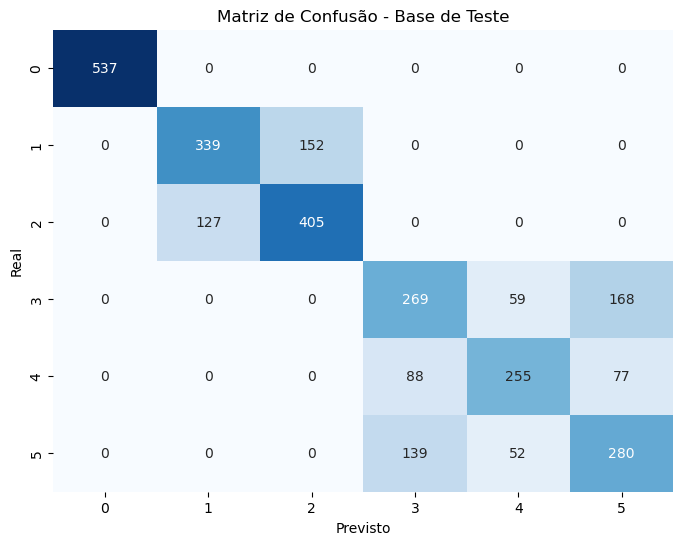

CPU times: total: 406 ms
Wall time: 469 ms


In [12]:
%%time
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Treinar o modelo final com o melhor alpha
melhor_arvore = DecisionTreeClassifier(random_state=42, ccp_alpha=melhor_alpha)
melhor_arvore.fit(X_treino_reduzido, y_treino)

# Fazer previsões na base de teste
y_pred = melhor_arvore.predict(X_test_reduzido)

# Avaliar desempenho
acuracia_teste = accuracy_score(y_test, y_pred)
print(f"Acurácia final na base de teste: {acuracia_teste:.4f}\n")

print("Relatório de classificação:\n")
print(classification_report(y_test, y_pred))

# Matriz de confusão
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Matriz de Confusão - Base de Teste")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.show()